# Transformer

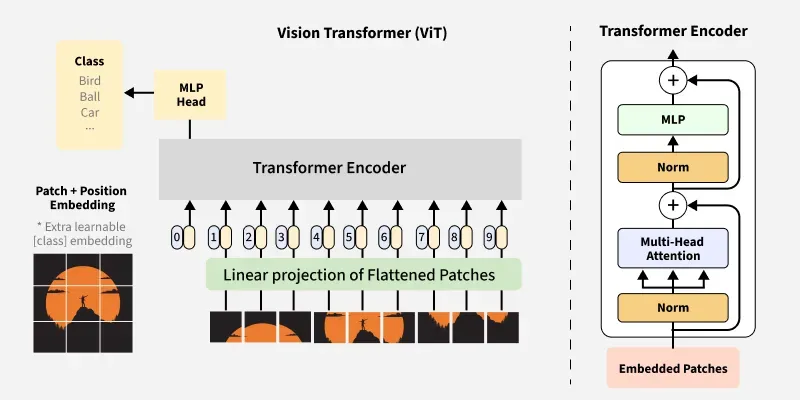

What is Linear projection of flattened patches? It is a patchification, which is often done using convolution with kernel and stride size equal to the patch size. Using this convolution settings, the convolution kernels do not overlap. Convolution acts as first stage feature extractor - it has learnable kernels. Its number of output channels is the embed size. Using convolution is the most common way of patchification, but any other method could be used - try to come up with an alternative.

## Linear Projection - Patchification
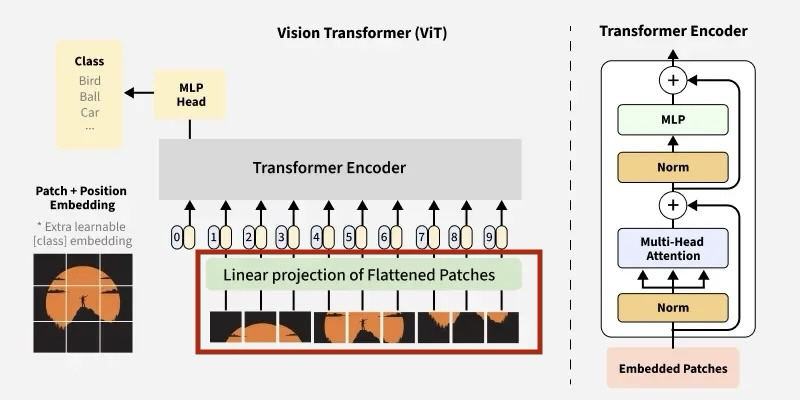

In [1]:
import torch

batch_size = 2
embed_size = 512
patch_size = 16
res = 224
# resolution should be divisible by patch size,
# otherwise the unfitting part would be removed and information lost
assert res % patch_size == 0

image = torch.randn(3,res,res)
batch = torch.stack([image for _ in range(batch_size)])  # create a batch
print(f"we have a batch with shape batch_size x channels x height x width:\n{batch.shape}")

# patchify using convolution
conv = torch.nn.Conv2d(
    in_channels=3,
    out_channels=embed_size,
    kernel_size=(patch_size, patch_size),
    stride=(patch_size, patch_size)
    )
patches = conv(batch)
print(f"we have patches with shape batch_size x embed_size x patch_size x patch_size:\n{patches.shape}")

# spatial information je jeste zachovana, muzeme reverznout reshape.
tokens = patches.reshape(batch_size, -1, embed_size)
print(f"We turn patches into tokens by squashing the spatial dimensions into one dimension:\n{res // patch_size} * {res // patch_size} = {tokens.shape[-2]}\n{tokens.shape}")
print(tokens.shape) # 2, 14*14, 512

we have a batch with shape batch_size x channels x height x width:
torch.Size([2, 3, 224, 224])
we have patches with shape batch_size x embed_size x patch_size x patch_size:
torch.Size([2, 512, 14, 14])
We turn patches into tokens by squashing the spatial dimensions into one dimension:
14 * 14 = 196
torch.Size([2, 196, 512])
torch.Size([2, 196, 512])


The linear projection is done, we turned a RGB image into patches. We kept the batch dimension, turned the 3 channels into `embed_size` and squashed the 2D spatial dimension into one dimension. The spatial information is not lost, because we can revert the `reshape` operation in last part.

## CLS Token

Model will use the `cls_token` as a register and at the end of the model, it will aggregate the output decision of neural network into it. This is done instead of applying global average pooling on the output tokens. Later dinov3 shows that transformers benefit from having even more registers than one `cls_token` (which are still all aggregated into one output token). The cls_token has the same number of channels (`embed_size`) as other tokens. Also the initial values in `cls_token` are learned by the transformer during the training. It acts as weights during training, but as additional input to the network during an inference - we could say. BUT FOR NOW and for simplicity, we will just set it to random values. `cls_token` is usually on 0th index in the list of tokens.


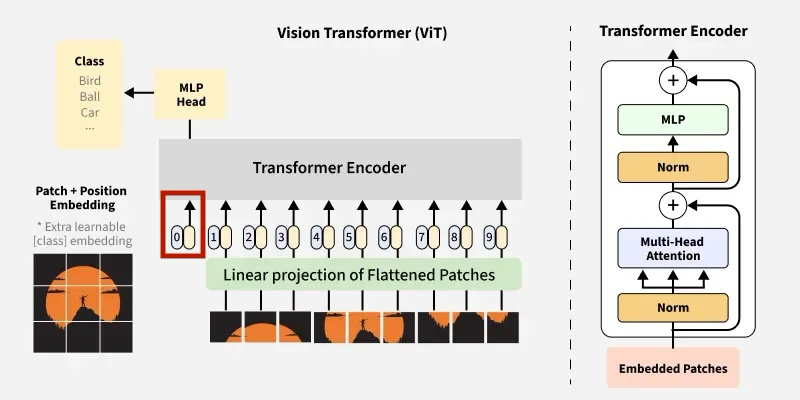

In [6]:
# cls token je vlastne ucitelny parametr, neni inicializovany nahodne pri vstupu,
# ale je trenovany jako vaha, ktera potom vstupuje do site jako vstup
cls_token = torch.randn(batch_size, 1, embed_size)
print(f"cls_token shape is: {cls_token.shape}")
# prvni je vzdycky cls, na pozici 0
print(f"Before adding cls_token, tokens shape is: {tokens.shape}")
tokens = torch.cat([cls_token, tokens], dim=1)
print(f"After adding cls_token on index 0, tokens shape is: {tokens.shape}")
# dinov2 pridalo registry (dalsi cls tokeny)


cls_token shape is: torch.Size([2, 1, 512])
Before adding cls_token, tokens shape is: torch.Size([2, 197, 512])
After adding cls_token on index 0, tokens shape is: torch.Size([2, 198, 512])


## Positional embedding

We *are* able to programatically revert the `patches.reshape` operation which removed the spatial information from our input. But we do not want to do it - the model will be able to pair each token with its position using positional token embedding. This is a num_tokens x embed_dim size which is added to each input image along the batch. This could be done somehow using sin/cos, or ROPE (in eva), but now we will make it only as a placeholder just for simplicity - so it will not work for now. We will also put there batch size - it is not correct, but we will ommit this mistake just for simplicity to move further.

In [3]:
# batch size is wrong, it also should not be random TODO
pos_token = torch.randn(batch_size, tokens.shape[1], embed_size)
print(f"pos_token shape is the same as tokens: {pos_token.shape}")
tokens = tokens + pos_token

pos_token shape is the same as tokens: torch.Size([2, 197, 512])


## Self attention (SA)
SA is the computantional core of the transformer. In comparison with CNN, which needs many layers to have large receptive field, transformer has complete receptive field over whole image right on the first layer. CNN learns what it sees. Transformer learns what it sees AND how to see it. We could say that the difference between transformer and CNN is that the CNN filters are fixed, while transformer has each inference different filters (transformer does not have filters exactly, this is just simplified comparison). We will start with description of Self Attention and then we will extend it into Multi-head Self Attention (MHSA).


`inner_embed_size` is the ize of embedding in transformer block, which differs from standard embedding size.

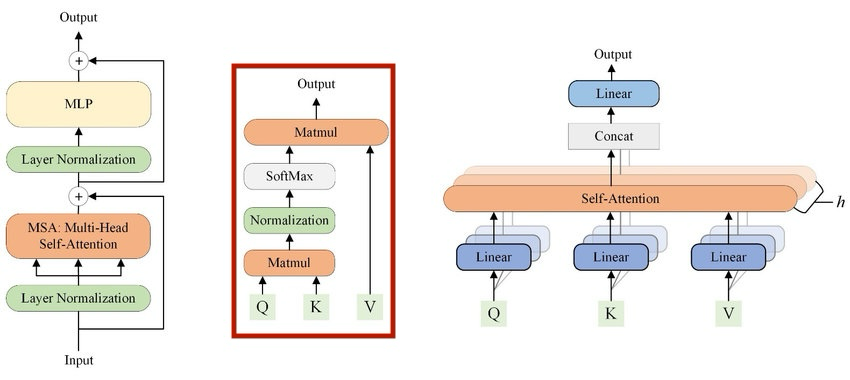

In [5]:

number_of_blocks = 5


inner_embed_size = int(embed_size * 1.5)
for i in range(number_of_blocks):
    # skip connection
    tokens_before = tokens.clone()
    tokens = torch.nn.LayerNorm(embed_size)(tokens) # normalizace
    # q k v vychazeji z jednoho vstupniho tokenu 
    # dimenze hsa byva obvykle 1.5 nasobkem embed size
    # Ty bloky jsou identicke, nezvetsuji se hloubeji v neuronce
    q_tokens = torch.nn.Linear(embed_size, inner_embed_size)(tokens)
    k_tokens = torch.nn.Linear(embed_size, inner_embed_size)(tokens)
    v_tokens = torch.nn.Linear(embed_size, inner_embed_size)(tokens)
    print(f"q_tokens shape: {q_tokens.shape}") # 2, 197, 768
    print(f"k_tokens shape: {k_tokens.shape}") # 2, 197, 768
    print(f"k_tokens shape T {k_tokens.transpose(-2, -1).shape}") # 2, 768, 197
    print(f"v_tokens shape: {v_tokens.shape}") # 2, 197, 768
    qk_tokens = torch.matmul(q_tokens, k_tokens.transpose(-2, -1)) # jest se to casto deli nejakou konstantou, to je detail
    qk_tokens = torch.nn.Softmax(dim=-1)(qk_tokens)
    print(f"qk_tokens shape: {qk_tokens.shape}") # 2, 197, 197

    qkv_tokens = torch.matmul(qk_tokens, v_tokens) # tohle je broadcastovane nebo tak nejak

    tokens = torch.nn.Linear(inner_embed_size, embed_size)(qkv_tokens)

    print(f"qk_tokens shape: {qk_tokens.shape}") # 2, 197, 197
    print(f"qkv_tokens shape: {qkv_tokens.shape}") # 2, 197, 768

    tokens = tokens_before + tokens
    tokens_before = tokens.clone()
    # to co vyleze z mhsa neni normalizovane
    tokens = torch.nn.LayerNorm(embed_size)(tokens)
    tokens = torch.nn.Linear(embed_size, embed_size)(tokens)

    tokens = tokens_before + tokens
    print("")

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: torch.Size([2, 197, 768])

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: torch.Size([2, 197, 768])

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: torch.Size([2, 197, 768])

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T

In [4]:
# TRANSFORMER BLOCK
# SINGLE HEAD ATTENTION
number_of_blocks = 5

inner_embed_size = int(embed_size * 1.5)
for i in range(number_of_blocks):
    tokens_before = tokens.clone()
    tokens = torch.nn.LayerNorm(embed_size)(tokens) # normalizace
    # q k v vychazeji z jednoho vstupniho tokenu 
    # dimenze hsa byva obvykle 1.5 nasobkem embed size
    # Ty bloky jsou identicke, nezvetsuji se
    q_tokens = torch.nn.Linear(embed_size, inner_embed_size)(tokens)
    k_tokens = torch.nn.Linear(embed_size, inner_embed_size)(tokens)
    v_tokens = torch.nn.Linear(embed_size, inner_embed_size)(tokens)
    print(f"q_tokens shape: {q_tokens.shape}") # 2, 197, 768
    print(f"k_tokens shape: {k_tokens.shape}") # 2, 197, 768
    print(f"k_tokens shape T {k_tokens.transpose(-2, -1).shape}") # 2, 768, 197
    print(f"v_tokens shape: {v_tokens.shape}") # 2, 197, 768
    qk_tokens = torch.matmul(q_tokens, k_tokens.transpose(-2, -1)) # jest se to casto deli nejakou konstantou, to je detail
    qk_tokens = torch.nn.Softmax(dim=-1)(qk_tokens)

    qkv_tokens = torch.matmul(qk_tokens, v_tokens) # tohle je broadcastovane nebo tak nejak

    tokens = torch.nn.Linear(inner_embed_size, embed_size)(qkv_tokens)

    print(f"qk_tokens shape: {qk_tokens.shape}") # 2, 197, 197
    print(f"qkv_tokens shape: {qkv_tokens.shape}") # 2, 197, 768

    tokens = tokens_before + tokens
    tokens_before = tokens.clone()
    # to co vyleze z mhsa neni normalizovane
    tokens = torch.nn.LayerNorm(embed_size)(tokens)
    tokens = torch.nn.Linear(embed_size, embed_size)(tokens)

    tokens = tokens_before + tokens
    print("")

# TRANSFORMER BLOCK 
# MULTIHEAD ATTENTION

# TRANSFORMER BLOCK

number_of_blocks = 5
num_heads = 8

inner_embed_size = int(embed_size * 1.5)
for i in range(number_of_blocks):
    tokens_before = tokens.clone()
    tokens = torch.nn.LayerNorm(embed_size)(tokens) # normalizace
    tokens= tokens.reshape((batch_size, num_heads, -1, embed_size // num_heads))
    #mhsa
    # q k v vychazeji z jednoho vstupniho tokenu 
    # dimenze mhsa byva obvykle 1.5 nasobkem embed size
    # Ty bloky jsou identicke, nezvetsuji se
    # qkv fuse potom funguje tak ze je jen jedna linear ale ma 3x vystup
    q_tokens = torch.nn.Linear(embed_size//num_heads, inner_embed_size // num_heads)(tokens)
    k_tokens = torch.nn.Linear(embed_size//num_heads, inner_embed_size // num_heads)(tokens)
    v_tokens = torch.nn.Linear(embed_size//num_heads, inner_embed_size // num_heads)(tokens)

    print(f"q_tokens shape: {q_tokens.shape}") # 2, 197, 768
    print(f"k_tokens shape: {k_tokens.shape}") # 2, 197, 768
    print(f"k_tokens shape T {k_tokens.transpose(-2, -1).shape}") # 2, 768, 197
    print(f"v_tokens shape: {v_tokens.shape}") # 2, 197, 768
    qk_tokens = torch.matmul(q_tokens, k_tokens.transpose(-2, -1)) # jest se to casto deli nejakou konstantou, to je detail
    qk_tokens = torch.nn.Softmax(dim=-1)(qk_tokens)

    qkv_tokens = torch.matmul(qk_tokens, v_tokens) # tohle je broadcastovane nebo tak nejak

    tokens = torch.nn.Linear(inner_embed_size // num_heads, embed_size // num_heads)(qkv_tokens)

    tokens = tokens.reshape((batch_size, -1, embed_size))

    print(f"qk_tokens shape: {qk_tokens.shape}") # 2, 197, 197
    print(f"qkv_tokens shape: {qkv_tokens.shape}") # 2, 197, 768

    tokens = tokens_before + tokens
    tokens_before = tokens.clone()
    # to co vyleze z mhsa neni normalizovane
    tokens = torch.nn.LayerNorm(embed_size)(tokens)
    tokens = torch.nn.Linear(embed_size, embed_size)(tokens)

    tokens = tokens_before + tokens
    print("")

# kdyz mam konvolucku, tak potrebuju spoooustu vrstev pro to abych mel velky receptive field
# transformer umi delat globalni attention hned od zacatku
# transformer umi lepe pracovat s long range dependencies

# konvolucka se uci co vidi
# transformer se uci jak se na to koukat a potom co vidi

# v transformeru jsou ty filtry pri kazde inferenci jine, navic vstup volnosti

# KAzda heda vidi cely obrazek! co nevidi je cely embed, ma jen jeho cast. Ale ma celou spatial informaci

# kazda vrstva transformeru zpresnuje vysledek

# --------------



num_classes = 10

linear = torch.nn.Linear(in_features=embed_size, out_features=num_classes)
out = linear(tokens[:,0:1,:])
print(out.shape)

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: torch.Size([2, 197, 768])

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: torch.Size([2, 197, 768])

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: torch.Size([2, 197, 768])

q_tokens shape: torch.Size([2, 197, 768])
k_tokens shape: torch.Size([2, 197, 768])
k_tokens shape T torch.Size([2, 768, 197])
v_tokens shape: torch.Size([2, 197, 768])
qk_tokens shape: torch.Size([2, 197, 197])
qkv_tokens shape: